---
title: "The Covariance Matrix from Scratch"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2024-5-31"
categories: ['Python', 'Linear Algebra']
image: thumbnail.png
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
editor: 
  markdown: 
    wrap: 72
---

In [1]:
#| code-fold: true
import numpy as np
import pandas as pd
import ucimlrepo
import sympy as sp
import matplotlib.pyplot as plt

The following is an overview of how to construct a covariance matrix. The post is largely based on exercises in [@cohen_practical_2022], an excellent overview of applied, numerical linear algebra in python. I overview how to construct a covariance matrix, but in the process I try to touch on a lot of important concepts in fundamental linear algebra: matrix multiplication, matrix transformations, the centering matrix, and getting from the idea of a matrix operation to the formal notation.

I want to stress that the methods and procedures that I overview here are examples of *analytical* linear algebra. I'm looking at a lot of pen and paper methods for defining operations. In *numerical* linear algebra, where we actually compute this stuff on data, methodology is different. If you look into how `numpy` computes covariance, it's not going to look anything like this. However, learning these analytical fundamentals has value -- both in making it easier to read linear algebra heavy textbooks, and in being able to write out operations and ideas in parsimonious mathematical statements.

# Question and Data
In [@cohen_practical_2022], the covariance exercises are based on the ["Communities and Crime," dataset from the UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/183/communities+and+crime), which includes data on:  

> Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.  
>

I'll use the same data.

In [2]:
#| code-fold: true
# Fetch the dataset 
communities_and_crime: ucimlrepo.dotdict = ucimlrepo.fetch_ucirepo(id=183) 
df: pd.DataFrame = pd.concat([communities_and_crime.data.features,
                              communities_and_crime.data.features], axis=1)
# Isolate numerical features and clear duplicate columns
df_num: pd.DataFrame = df.copy().select_dtypes(include='number')
df_num = df_num.loc[:,~df_num.columns.duplicated()]
df_num = df_num.iloc[:, 2:]

To make the operations as clear as possible, I'm going to focus on the first five rows and first two columns for the majority of this post.

In [3]:
example = df_num.head()[['population', 'householdsize']]
example

,population,householdsize
0,0.19,0.33
1,0.00,0.16
2,0.00,0.42
3,0.04,0.77
4,0.01,0.55


## The summation formulation
Say we have two columns, `population` and `householdsize`, and we'd like to know to what degree they are associated. I'll refer to these as `x` and `y`, respectively.

In [4]:
x = example['population']
y = example['householdsize']

I can compute their covariance statistic via the following equation, where $x$ is `population`, and $y$ is `householdsize`

$$
c_{x, y} = (n-1)^{-1} \sum_{i=1} ^n (x_i - \bar{x})(y_i - \bar{y})
$${#eq-one}
[@cohen_practical_2022, chapter 7]

I'll create a function that makes the equation operational for any two arrays, `x` and `y`:

In [5]:
def bivariate_cov(x: np.array, y: np.array) -> float:
    x_bar: float = x.mean()
    y_bar: float = y.mean()
    n = len(x)
    summation = 0
    for i in range(n):
        summation += (x.loc[i] - x_bar) * (y.loc[i] - y_bar)
    return summation / (n-1)

For `population` and `householdsize` the covariance statistic is:

In [6]:
print("cov(x, y):", bivariate_cov(x, y))

cov(x, y): -0.0020099999999999996


I'll check my answer with a built in function, `numpy.cov()`:

In [7]:
np.cov(x, y)

array([[ 0.00657, -0.00201],
       [-0.00201,  0.05293]])

This is clearly different! Rather than a scalar, this function returned a matrix. However, the upper and lower triangles of the matrix are the same as the covariance value we computed. Indeed, what numpy returned for covariance is the following matrix:
$$
C = 
\left[
\begin{matrix}
    var(x) & cov(x, y) \\
    cov(y, x) & var(y) \\
\end{matrix}
\right]
$${#eq-cov-matrix}

We can compute the variances of $x$ and $y$ to confirm this (note that variance is a special case of covariance where the `x` and `y` input are equal) 

In [8]:
print("var(x):", bivariate_cov(x, x))
print("var(y):", bivariate_cov(y, y))

var(x): 0.006570000000000002
var(y): 0.05293000000000001


But how do we get the linear algebra formula that `numpy` used to produce that matrix, $C$?

## The vector formulation
To get our output to match numpy's we'll start by generalizing the covariance equation to input vectors. Recall the summation equation:

$$
\begin{align*}
c_{x, y} &= (n-1)^{-1} \sum_{i=1} ^n (x_i - \bar{x})(y_i - \bar{y}) \\
\end{align*}  
$$  

To convert this into an equation that uses vectors, we'll note that the $\sum_{i=1}^n(\cdots)_i(\cdots)_i$ term above corresponds to a "dot product" in linear algebra. We write this out as follows:
$$
\begin{align*}
c_{x, y} &= (n-1)^{-1}(\mathbf {x}_{n \times 1} - \bar{\mathbf {x}})^\intercal (\mathbf {y}_{n \times 1} - \bar{\mathbf {y}}) \\
\end{align*}  
$$

[@cohen_practical_2022, chapter 7]  

Note the following notational conventions:  

- the boldface x, $\mathbf {x}_{n \times 1}$ refers to a vector with dimensions $n \times 1$ and all the elements $x_i$, $i \in [1,2, \cdots, n]$
- $\bar{\mathbf {x}}$ and $\bar{x}$ are equivalent -- both represent the mean of the vector.
- $^\intercal$ represents the transpose. The short of this is that $(\mathbf {x}_{n \times 1} - \bar{\mathbf {x}})$ is an $n \times 1$ vector. When we transpose it, it becomes a $1 \times n$ vector, which is necessary for this multiplication to work. I'm going to go into detail on this a little later, but for now just know that transposing a vector switches its row and column dimensions. For example, here we convert a column, $n \times 1$ vector into a row, $1 \times n$ vector:  

$$
\left[\begin{matrix}x_1\\x_2\\x_3\\x_4\\x_5\end{matrix}\right]_{n \times 1}^\intercal = \left[\begin{matrix}x_1&x_2&x_3&x_4&x_5\end{matrix}\right]_{1 \times n}
$$

Rather than overview every rule of linear algebra operations now, I'll compute the covariance of the two variables in our dataset and we can directly examine how basic vector-scalar and vector-vector operations come out.  
I'll denote the vectors and their means below:

In [9]:
print("x:", x.values, "\nmean(x)=", x.mean())
print("y:", y.values,  "\nmean(y)=", y.mean())
print("n = ", len(x))

x: [0.19 0.   0.   0.04 0.01] 
mean(x)= 0.048
y: [0.33 0.16 0.42 0.77 0.55] 
mean(y)= 0.446
n =  5


And we can now plug everything into that vector formula for covariance:

$$
\begin{align*}
c_{x, y} &= (n-1)^{-1}(\mathbf {x}_{n \times 1} - \bar{\mathbf {x}})^\intercal (\mathbf {y}_{n \times 1} - \bar{\mathbf {y}}) \\
 &= \frac{1}{4} (\left[\begin{matrix}0.19\\0\\0\\0.04\\0.01\end{matrix}\right] - 0.048)^\intercal (\left[\begin{matrix}0.33\\0.16\\0.42\\0.77\\0.55\end{matrix}\right] - 0.446) \\
 &= \frac{1}{4} (\left[\begin{matrix}0.142\\-0.048\\-0.048\\-0.008\\-0.038\end{matrix}\right]^\intercal \left[\begin{matrix}-0.116\\-0.286\\-0.026\\0.324\\0.104\end{matrix}\right]) \\
&= \frac{1}{4} ((0.142) (-0.116) + (-0.048) (-0.286) \\
&\quad \quad + (-0.048) (-0.026) + (-0.008) (0.324) \\
&\quad \quad + (-0.038) (0.104) )  \\
&\approx \frac{1}{4} (-0.00804) \\
&\approx -0.00201
\end{align*}
$$

In python we can confirm our result, where `@` computes the dot product in python's `numpy` library:

In [10]:
x_bar: float = x.mean()
y_bar: float = y.mean()
n = len(x)
((x - x_bar).T @ (y - y_bar)) / (n - 1)

-0.0020099999999999996

## Deriving the matrix formulation
The vector formulation is not particularly useful, so we will quickly move on to the matrix formulation, which will produce output equivalent to `np.cov()`. 

Before we get to the equation, we'll start by defining a matrix, $X$, made up of the vectors $\mathbf{x}$ and $\mathbf{y}$:  
$$
X_{n \times 2} = 
\left[
\begin{matrix}
\vert & \vert \\
    \mathbf{x}   & \mathbf{y}   \\
    \vert & \vert
\end{matrix}
\right]_{n \times 2} = \left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2}
$$  

This is really just our full dataset:

In [11]:
X = example[['population', 'householdsize']]
X

,population,householdsize
0,0.19,0.33
1,0.00,0.16
2,0.00,0.42
3,0.04,0.77
4,0.01,0.55


Now we want to create a currently unknown operation that will take in this matrix, $X$, and output the covariance matrix, (@eq-cov-matrix). In thinking about this, lets decompose what exactly that covariance matrix is, incorporating the simple summation formula, then the vector formula we just learned:

$$
\begin{align*}
???(X) &= 
\left[
\begin{matrix}
    var(x) & cov(x, y) \\
    cov(y, x) & var(y) \\
\end{matrix}
\right] \\
&=\left[
\begin{matrix}
\sum_{i=1}^{n} (x_i - \bar{\mathbf{x}})(x_i - \bar{\mathbf{x}}) & \sum_{i=1}^{n} (x_i - \bar{\mathbf{x}})(y_i - \bar{\mathbf{y}}) \\
\sum_{i=1}^{n} (y_i - \bar{\mathbf{y}})(x_i - \bar{\mathbf{x}}) & \sum_{i=1}^{n} (y_i - \bar{\mathbf{y}})(y_i - \bar{\mathbf{y}}) \\
\end{matrix}
\right] (n-1)^{-1}\\
&= \left[
\begin{matrix}
(\mathbf {x} - \bar{\mathbf {x}})^\intercal (\mathbf {x} - \bar{\mathbf {x}}) & (\mathbf {x} - \bar{\mathbf {x}})^\intercal (\mathbf {y} - \bar{\mathbf {y}}) \\
(\mathbf {y} - \bar{\mathbf {y}})^\intercal (\mathbf {x} - \bar{\mathbf {x}}) & (\mathbf {y} - \bar{\mathbf {y}})^\intercal (\mathbf {y} - \bar{\mathbf {y}}) \\
\end{matrix}
\right] (n-1)^{-1}
\end{align*}
$$
Set aside the value, $(n-1)^{-1}$ for now, and just consider what this matrix of dot products is made of.  

I defer to the [wikipedia entry on matrix-matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication#Vector_times_matrix) to define the exact process, but consider that when you multiply two matrices, each entry in the output matrix is the dot product of the $i$ th row of the left matrix and the $j$ th column of the right matrix. Given that definition and the fact that our output above is a matrix of dot products, lets define it as the output of a multiplication operation between some currently unknown left and right matrix. Specifically:  
 
$$
\begin{align*}
\left[
\begin{matrix}
(\mathbf {x} - \bar{\mathbf {x}})^\intercal (\mathbf {x} - \bar{\mathbf {x}}) & (\mathbf {x} - \bar{\mathbf {x}})^\intercal (\mathbf {y} - \bar{\mathbf {y}}) \\
(\mathbf {y} - \bar{\mathbf {y}})^\intercal (\mathbf {x} - \bar{\mathbf {x}}) & (\mathbf {y} - \bar{\mathbf {y}})^\intercal (\mathbf {y} - \bar{\mathbf {y}}) \\
\end{matrix}
\right] &= \\
\left[
\begin{matrix}
(\text{Row 1, Left Matrix}) \cdot (\text{Col 1, Right Matrix}) & (\text{Row 1, Left Matrix}) \cdot (\text{Col 2, Right Matrix})  \\
(\text{Row 2, Left Matrix}) \cdot (\text{Col 1, Right Matrix}) & (\text{Row 2, Left Matrix}) \cdot (\text{Col 2, Right Matrix})\\
\end{matrix}
\right]
\end{align*}
$$  

We can use the equivalence of these two statements to define what the rows and columns are for the left and right matrix:  

$$
\begin{align*}
C &= \left[
\begin{matrix}
    —&(\text{Row 1})  &—   \\
    —& (\text{Row 2}) &— 
\end{matrix}
\right]
\left[
\begin{matrix}
\vert & \vert \\
    (\text{Col 1})   & (\text{Col 2})   \\
    \vert & \vert
\end{matrix}
\right] (n-1)^{-1}\\
&=
\left[
\begin{matrix}
    —&(\mathbf{x}-\bar{\mathbf{x}})  &—   \\
    —& (\mathbf{y}-\bar{\mathbf{y}}) &— 
\end{matrix}
\right]
\left[
\begin{matrix}
\vert & \vert \\
    (\mathbf{x}-\bar{\mathbf{x}})   & (\mathbf{y}-\bar{\mathbf{y}})   \\
    \vert & \vert
\end{matrix}
\right] (n-1)^{-1}
\end{align*}
$$
This is a good time to explain how a matrix transpose works. We can see that the rows 1 and 2 of the left matrix are the same as the columns 1 and 2 of the right matrix. This means that the left matrix is a transpose of the right matrix (or vice versa).  

> I think it’s [...] easy to remember that **transposing swaps rows and columns**  
> -- [@cohen_practical_2022, chapter 5]  
>

$$
\left[
\begin{matrix}
\vert & \vert \\
    (\mathbf{x}-\bar{\mathbf{x}})   & (\mathbf{y}-\bar{\mathbf{y}})   \\
    \vert & \vert
\end{matrix}
\right]^\intercal = 
\left[
\begin{matrix}
    —&(\mathbf{x}-\bar{\mathbf{x}})  &—   \\
    —& (\mathbf{y}-\bar{\mathbf{y}}) &— 
\end{matrix}
\right]
$$

When we plug that in, we get the typical formula for covariance.

$$
\begin{align*}
 C &=
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}^\intercal
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2} (n-1)^{-1}
\end{align*}
$${#eq-cov-mat}  


So now we know the matrix operation that will yield the covariance matrix, $C$, from the matrix, $X$ -- we find the mean-centered representation of $X$, multiply that with itself, and then multiply the result by the scalar, $(n-1)^{-1}$. This is a fairly straightforward operation, but **it's not really an equation yet.** We will now formalize it into one.

### Building the centering matrix

We want to subtract the mean of x from the x elements, and the mean of y from the y elements, all in one matrix. In the vector setting above, we set this up as the difference between a vector and its scalar mean. Vector-scalar operations are intuitive in linear algebra: 

$$
\left[
\begin{matrix}
    x_1  \\
    x_2   \\
    \vdots   \\
    x_n 
\end{matrix}
\right]_{n \times 1} - \bar{\mathbf{x}} = \left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   \\
    x_2 - \bar{\mathbf{x}}    \\
    \vdots   \\
    x_n - \bar{\mathbf{x}}     \\
\end{matrix}
\right]_{n \times 1}
\, \text{ and } \,
\left[
\begin{matrix}
    y_1  \\
    y_2   \\
    \vdots   \\
    y_n 
\end{matrix}
\right]_{n \times 1} - \bar{\mathbf{y}} = \left[
\begin{matrix}
y_1 - \bar{\mathbf{y}}   \\
    y_2 - \bar{\mathbf{y}}    \\
    \vdots   \\
    y_n - \bar{\mathbf{y}}     \\
\end{matrix}
\right]_{n \times 1}
$$


In a matrix formulation, this is slightly different. 
  
> You add [or subtract] two matrices by adding their corresponding elements. [...]  
> Matrix addition [and subtraction] is **defined only between two
matrices of the same size.**
>
> -- [@cohen_practical_2022, chapter 5]

Therefore, we would set $x_i - \bar{x}$ and $y_i - \bar{y}$ up in a matrix formulation as follows:  

$$  
\left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2} - 
\left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2} = 
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
$$

But how do we produce the $n \times 2$ matrix of column means that this equation requires?  
$$
??? = \left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
$${#eq-mat-means}

 Given that these means are functions of the elements of $\mathbf{x}$ and $\mathbf{y}$ respectively, we are going to try to create a function that takes in the matrix $X$ and outputs the matrix of means above, (@eq-mat-means).

#### The mean as a matrix transformation
To build that function, lets start by considering a standard definition of the average and translate it into a "matrix transformation". The simple summation formulation for the mean is as follows:  
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i = \sum_{i=1}^n \frac{1}{n}x_i
$$
The summation, $\sum_{i=1}^n \frac{1}{n}x_i$, maps directly to a simple dot product:  
$$
\begin{align*}
\bar{x} &= \sum_{i=1}^n \frac{1}{n}x_i \\
&= \frac{1}{n}x_1 + \frac{1}{n}x_2 + \cdots \frac{1}{n}x_n \\
&= \left[\begin{matrix}\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}\end{matrix}\right]_{1 \times n} \left[\begin{matrix}x_1\\x_2\\\vdots\\x_n\end{matrix}\right]_{n \times 1}
\end{align*}
$$
This is interesting (really), because it looks like if we multiply $\left[\begin{matrix}\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}\end{matrix}\right]_{1 \times n}$ by any $n \times 1$ vector, we get the mean. So it seems like the following is a function that takes in a vector, multiplies it with another vector, and outputs the average of the input vector:
$$
\bar{x} = f(\mathbf{x}_{n \times 1}) = \left[\begin{matrix}\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}\end{matrix}\right]_{1 \times n} \mathbf{x}_{n \times 1}
$${#eq-simple-mean}
 
Lets confirm this behavior with code:

In [12]:
print("n =", len(x))
print("[1/n, 1/n, ... 1/n] = ", 1/len(x) * np.ones(len(x)).T)
print("x = ", x.values)
print()
print(
    "[1/n, 1/n, ... 1/n] @ x = ", round(1/len(x) * np.ones(len(x)).T @ x, 5)
    )
print("mean = ", x.mean())
print("^ these are equal")

n = 5
[1/n, 1/n, ... 1/n] =  [0.2 0.2 0.2 0.2 0.2]
x =  [0.19 0.   0.   0.04 0.01]

[1/n, 1/n, ... 1/n] @ x =  0.048
mean =  0.048
^ these are equal


Now that we've confirmed that the function works, lets create formal notation for it. Consider the vector of 1s, $\mathbf{1}$:  
$$
\mathbf{1}_{n \times 1} = \left[\begin{matrix}1\\1\\\vdots\\1\end{matrix}\right]_{n \times 1} \\
$$
If we mutliply that by $1/n$ and transpose the result, we get the vector from our function, (@eq-simple-mean):
$$
n^{-1}\mathbf{1}_{n \times 1}^\intercal = \left[\begin{matrix}\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}\end{matrix}\right]_{1 \times n}
$$  

With that notation, we'll now redefine the function as the matrix transformation, $T_\text{mean}$, that transforms a $n \times 1$ matrix (this is just a vector) into its scalar mean.
$$
T_\text{mean}: \mathbb{R}^n \rightarrow \mathbb{R}^1 \quad \text{defined by} \quad T(\mathbf{x}_{n \times 1}) = n^{-1}\mathbf{1}_{n \times 1}^\intercal \mathbf{x}_{n \times 1}
$$  

Looks weird and potentially useless, but we'll use this same approach to define notation for the matrix of deviations from the mean from (@eq-cov-mat)

#### Deviation from the mean as a matrix transformation

$T_\text{mean}$ yields a scalar, $\bar{x}$, and it could also easily be used to find $\bar{y}$, but I want the matrix:
$$
\left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
$$
To move towards that output, an $n \times 2$ matrix, lets consider some points about matrix multiplication.

#### An aside about matrix multiplication rules
In matrix multiplication, the following properties hold with regards to dimensions of the input and output:  

1. Operations are only valid if the column dimension of the left input matrix matches the row dimension of the right input matrix.
2. The output has the row dimension of the left matrix and the column dimension of the right matrix.

-- [@cohen_practical_2022, chapter 5]  

For example, in all of our previous vector $\times$ vector operations, our dimensionality was as follows:  
$$
\begin{align*}
(1 \times \fbox{n})(\fbox{n} \times 1) \quad& (n = n) \rightarrow \text{Operation is valid} \\
(\fbox{1} \times n)(n \times \fbox{1}) \quad& (1 \times 1) \rightarrow \text{Output is scalar} 
\end{align*}
$$
(Sometimes we had to transpose one of the vectors for this to be the case).  

If we want to produce an $n \times 2$ matrix from a multiplication operation involving an $n \times 2$ input (our data matrix, $X$), we would need a matrix with the following, underlined dimensionality:  
$$
\underline{(n \times n)} (n \times 2) \rightarrow \text{Valid with output: } (n \times 2)
$$
Upon some reflection, the $n \times n$ matrix must be the matrix where every element is $1/n$. The following operation gives us the desired matrix with all elements set as the original column mean:
$$
\left[
\begin{matrix}
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \vdots   & \vdots   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}
\end{matrix}
\right]_{n \times n}
\left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2} = 
\left[
\begin{matrix}
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}   \\
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}  \\
    \vdots   & \vdots   \\
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}   \\
\end{matrix}
\right]_{n \times 2} 
= \left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
$$

#### Notation of the transformation
We will need that matrix of $1/n$ values in our covariance matrix equation. We'll now formalize the construction of that matrix so that we can write it in an equation, much as we did for the scalar mean in the previous section.

We can construct a square matrix of 1s by multiplying the 1s vector with its transpose, $(n \times 1)(1 \times n) \rightarrow (n \times n)$. Then we can multiply the matrix by $1/n$, which will apply to each element in the matrix:  

$$
\begin{align*}
n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal &= n^{-1} \left[\begin{matrix}1\\1\\\vdots\\1\end{matrix}\right]_{n \times 1} \left[\begin{matrix}1 & 1 & \cdots & 1\end{matrix}\right]_{1 \times n} \\
&= n^{-1} \left[
\begin{matrix}
    1   & 1   & \cdots & 1\\
    1   & 1   & \cdots & 1\\
    \vdots   & \vdots   & \cdots & 1\\
    1   & 1   & \cdots & 1
\end{matrix}
\right]_{n \times n} \\
&= \left[
\begin{matrix}
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \vdots   & \vdots   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}
\end{matrix}
\right]_{n \times n}
\end{align*}
$$

Thus the transformation that creates the "matrix of means," (@eq-mat-means) is $n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal$ applied to an input matrix, $X$:  
$$
\begin{align*}
 n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal X_{n \times 2} &= \left[
\begin{matrix}
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \vdots   & \vdots   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}
\end{matrix}
\right]_{n \times n}
\left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2} \\
&= \left[
\begin{matrix}
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}   \\
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}  \\
    \vdots   & \vdots   \\
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}   \\
\end{matrix}
\right]_{n \times 2} \\
&= \left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
\end{align*}
$$

Finally, we'll use our "matrix of means" to yield the original matrix of interest used in (@eq-cov-mat), where each element is the deviation from its column mean:  

$$
\begin{align*}
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2} &= 
\left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2} - 
\left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}  \\
 &= X_{n \times m} -  n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal X_{n \times m} \\
 &=  (I_{n \times n} -  n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal ) X_{n \times m}
 \end{align*}
$$
(*note the [identity matrix, $I$](https://en.wikipedia.org/wiki/Identity_matrix), which, in matrix multiplication, acts like a $1$ would in scalar multiplication*)  


At this point, we will discard some of the dimension information about the matrices, which I've previously been using as guardrails, and simplify notation as follows:
$$
\begin{align*}
  &= (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X
\end{align*}
$$

This yields the function for mean centering the matrix, commonly referred to as the [centering matrix](https://en.wikipedia.org/wiki/Centering_matrix):  
$$
T_{\text{center}}: \mathbb{R}^n \rightarrow \mathbb{R}^n \quad \text{defined by} \quad T(X) = (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X
$$ 

In code:

In [13]:
def T_center(X: np.array) -> np.array:
    n = len(X)
    return (np.identity(n) - (1/n)*np.ones(shape=(n, n))) @ X

### A note on broadcasting and numerical methods  

`numpy` and `pandas` support some invalid linear algebra operations, such as matrix addition/subtraction between different sized matrices (these packages use a method called [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) to make the operations valid):  

![Broadcasting a times b](broadcasting_1.png)  

This makes the sort of centering operation we just covered in depth incredibly simple:

In [14]:
X - X.mean()

,population,householdsize
0,0.142,-0.116
1,-0.048,-0.286
2,-0.048,-0.026
3,-0.008,0.324
4,-0.038,0.104


We can confirm that our function produced that same centered matrix:

In [15]:
T_center(X)

,population,householdsize
0,0.142,-0.116
1,-0.048,-0.286
2,-0.048,-0.026
3,-0.008,0.324
4,-0.038,0.104


At this point we will return to the matrix equation for covariance, (@eq-cov-mat) that we defined earlier:
$$
\begin{align*}
C = (n-1)^{-1} \left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}^\intercal
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
\end{align*}
$$  

We'll now express it formally.

## The matrix formulation

Covariance is fairly simple to write out once you have the centering matrix, $T_{\text{center}}$. Our equation is as follows:

$$
\begin{align*}
C &= (n - 1)^{-1} T_{\text{center}}(X)^\intercal T_{\text{center}}(X)  \\
&= (n - 1)^{-1}\left[ (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X \right]^\intercal \left[ (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X \right]
\end{align*}
$$
This is pretty verbose, and it's common in textbooks to see some sort of abbreviated version, like the following,
$$
\begin{align*}
C = (n - 1)^{-1} X_c^\intercal X_c \\
\text{where }X_c = (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X
\end{align*}
$${#eq-cov}  

[@cohen_practical_2022, chapter 7]  

In [16]:
def covariance_matrix(X: np.array) -> np.array:
    n = len(X)
    # Center matrix
    X_c = T_center(X)
    # Compute covariance
    return 1/(n-1) * X_c.T @ X_c

### Applying it to data

We'll test this formula out with our data:

In [17]:
X

,population,householdsize
0,0.19,0.33
1,0.00,0.16
2,0.00,0.42
3,0.04,0.77
4,0.01,0.55


First we'll define the centered matrix, $X_c = (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X$:

In [18]:
#| code-fold: true
C, X_c = sp.symbols("C X_c")
exp = (sp.UnevaluatedExpr(sp.Matrix(np.identity(n).astype(int))) - sp.UnevaluatedExpr(1/n) * sp.UnevaluatedExpr(sp.Matrix(np.ones(shape=(n, 1)) @ np.ones(shape=(n, 1)).T))) * sp.UnevaluatedExpr(sp.Matrix(X))
exp_output = (sp.Matrix(
    np.round((np.identity(n) - (1/n) * np.ones(shape=(n, 1)) @ np.ones(shape=(n, 1)).T) @ X, 3)
    ))
sp.Eq(X_c, exp)

Eq(X_c, (-0.2*Matrix([
[1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0]]) + Matrix([
[1, 0, 0, 0, 0],
[0, 1, 0, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1]]))*Matrix([
[0.19, 0.33],
[   0, 0.16],
[   0, 0.42],
[0.04, 0.77],
[0.01, 0.55]]))

Which evaluates to:

In [19]:
#| code-fold: true
sp.Eq(X_c, sp.UnevaluatedExpr(exp_output))

Eq(X_c, Matrix([
[ 0.142, -0.116],
[-0.048, -0.286],
[-0.048, -0.026],
[-0.008,  0.324],
[-0.038,  0.104]]))

And now the main equation:
$$
C = (n - 1)^{-1} X_c^\intercal X_c
$$

In [20]:
#| code-fold: true
out = (
    sp.UnevaluatedExpr(exp_output.T) * sp.UnevaluatedExpr(exp_output.evalf())
    * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1))
    )
sp.Eq(C, out)

Eq(C, Matrix([
[ 0.142, -0.048, -0.048, -0.008, -0.038],
[-0.116, -0.286, -0.026,  0.324,  0.104]])*Matrix([
[ 0.142, -0.116],
[-0.048, -0.286],
[-0.048, -0.026],
[-0.008,  0.324],
[-0.038,  0.104]])*(-1 + 5)**(-1))

Already it should become apparent that this multiplication will be a sequential application of the vector formula for covariance. We can make that abundantly clear by visualizing the multiplication result:

In [21]:
#| code-fold: true
out = sp.Matrix([[sp.UnevaluatedExpr(sp.Matrix(x-x.mean()).T) * sp.UnevaluatedExpr(sp.Matrix(x-x.mean()))
                  * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1)),
                  sp.UnevaluatedExpr(sp.Matrix(x-x.mean()).T) * sp.UnevaluatedExpr(sp.Matrix(y-y.mean()))
                  * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1))],
                  [sp.UnevaluatedExpr(sp.Matrix(y-y.mean()).T) * sp.UnevaluatedExpr(sp.Matrix(x-x.mean()))
                   * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1)),
                   sp.UnevaluatedExpr(sp.Matrix(y-y.mean()).T) * sp.UnevaluatedExpr(sp.Matrix(y-y.mean()))
                   * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1))]
                   ])
out

Matrix([
[Matrix([[0.142, -0.048, -0.048, -0.008, -0.038]])*Matrix([
[ 0.142],
[-0.048],
[-0.048],
[-0.008],
[-0.038]])*(-1 + 5)**(-1), Matrix([[0.142, -0.048, -0.048, -0.008, -0.038]])*Matrix([
[-0.116],
[-0.286],
[-0.026],
[ 0.324],
[ 0.104]])*(-1 + 5)**(-1)],
[ Matrix([[-0.116, -0.286, -0.026, 0.324, 0.104]])*Matrix([
[ 0.142],
[-0.048],
[-0.048],
[-0.008],
[-0.038]])*(-1 + 5)**(-1),  Matrix([[-0.116, -0.286, -0.026, 0.324, 0.104]])*Matrix([
[-0.116],
[-0.286],
[-0.026],
[ 0.324],
[ 0.104]])*(-1 + 5)**(-1)]])

The result:

In [22]:
covariance_matrix(X.values)

array([[ 0.00657, -0.00201],
       [-0.00201,  0.05293]])

For a sanity check, we can compare our results with those in `numpy` and `pandas`.

`numpy` results:

In [23]:
np.cov(x, y)

array([[ 0.00657, -0.00201],
       [-0.00201,  0.05293]])

`pandas` results:

In [24]:
X.cov()

,population,householdsize
population,0.00657,-0.00201
householdsize,-0.00201,0.05293


#### Visualizing the Covariance Matrix
We'll now return to our original, full dataset from the very start of the exercise.

In [25]:
df_num.shape

(1994, 99)

and we'll compute the covariance matrix across al 99 features.

In [26]:
cov_matrix = covariance_matrix(df_num)

cov_matrix.shape

(99, 99)

Looking at a $99 \times 99$ matrix is not particularly useful, so it's common to use heatmaps to visualize matrices that show association between many variables.

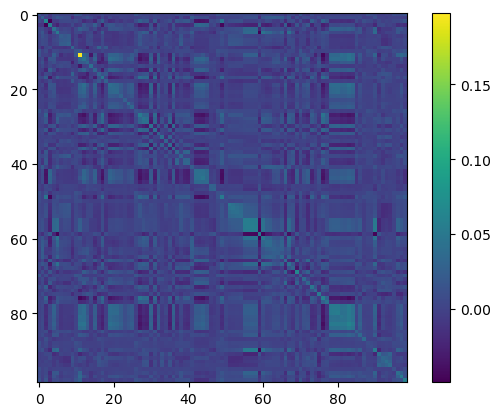

In [27]:
plt.imshow(cov_matrix.values)
plt.colorbar();

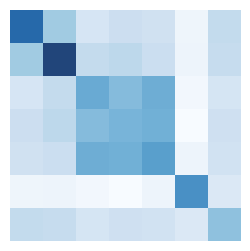

In [41]:
#| output: false
#| echo: false
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cov_matrix.values[4:11, 4:11], cmap="Blues", alpha=.9)
ax.axis("off")
# fig.tight_layout()
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=400)

While this looks cool, I view it as more or less useless as a tool for doing any sort of exploration.

The covariances between variables are highly [influenced by the scale of the original variables](https://en.wikipedia.org/wiki/Covariance_and_correlation#:~:text=Notably%2C%20correlation%20is%20dimensionless%20while%20covariance%20is%20in%20units%20obtained%20by%20multiplying%20the%20units%20of%20the%20two%20variables.). This matrix visualization be much more useful if we convert it into a **correlation matrix**, $R$, wherein the measures of association, $\rho_{i,j}$ are all normalized, $\rho_{i,j} \in [-1, 1]$. This in effect adjusts our measures for scale and allows us to actually see which variables are the most associated.  

I'll cover that matrix in a coming blog post...